# Test Technique  (bonus)

**Author:** [Yannis Tannier](https://github.com/yannistannier)<br>
**Date created:** 2021/10/16<br>
**Last modified:** 2021/10/19<br>

## Test without augmentation

In [29]:
import os
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


On définit nos hyperparamètres 

In [5]:
BATCH_SIZE = 32
NUM_CLASSES = 50
IMG_SIZE = 120

On doit à présent récupérer notre jeu d'entrainement et de test :

In [28]:
train_val = pd.read_csv("train_val.csv")
test = pd.read_csv("test.csv")

Notre première approche consiste en un fine-tuning d'un EfficientNet-B0.   

Pour cela nous importons **EfficientNetB0** de keras application avec le paramètre weights à "imagenet" car nous voulons importer les poids du modèle entrainé sur ImageNet. ImageNet étant une base de données composées de plus d'un million d'images, les valeurs des kernels (= les poids du modèle) appris sur ImageNet sont de la grande valeur. Même si notre jeu de données ne ressemble pas exactement aux images d'ImageNet, il est souvent plus intéressant de récupérer les poids d'un modèle entrainé sur ImageNet que d'initialiser les poids de façon aléatoire.   

On ajoute 4 couches après notre backbone (EfficientNetB0):    
- Une couche de GlobalAveragePooling2D pour réduire la dimension des features maps de sortie du backbone et également "aplatir" la matrice (l'équivalent d'un reshape d'une matrice 3D à 2D)
- Suivi d'une couche de BatchNormalization qui fait office de régularisation
- Puis d'une couche de Dropout, toujours pour régulariser notre réseau
- Et enfin une couche de Dense avec softmax avec N (le nombre de neurones) égale à notre nombre de label

L'entrainement se fera en 2 temps :    
- Premièrement nous allons de freeze toutes les couches de notre backbone (les couches d'EfficientNetB0) et entrainer avec un important learning (1e-2) puis le baisser progressivement jusqu'à (1e-4). Nous faisons cela car nous allons ajouter de nouvelle couches à notre réseau et nous voulons d'abord entrainer ces nouvelles couches afin de ne pas trop modifier les valeurs des poids du réseau au début de l'apprentissage, là où l'erreur sera la plus grande et donc le gradient élevée lors de la back propagation.   


- Dans un second temps, nous allons unfreeze la quasi-totalité du réseau et entrainer avec un faible learning rate (1e-4). Ce deuxième entrainement permet de spécialiser notre réseau dans son ensemble à la tache souhaitée.

In [7]:
def build_model(learning_rate=1e-2):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
    
    output = model.output
  
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(50, activation="softmax", name="logit")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetb0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')]
    )
    return model

In [12]:
def run_train(model, train_generator, val_generator, epochs, save_weights="model_best.h5", verbose=1):
    def scheduler(epoch, lr):
        if epoch < 30:
            return lr
        if epoch < 100:
            return lr*0.1
        return lr*0.01

    if verbose > 0:
        print("First Training : Backbone freeze\n")
    
    freeze_hist = model.fit(train_generator, 
                            epochs=epochs, 
                            validation_data=val_generator, 
                            verbose=verbose,
                            use_multiprocessing = True,
                            max_queue_size=20,
                            workers = 20,
                            callbacks=[
                                tf.keras.callbacks.LearningRateScheduler(scheduler)
                            ])
    
    if verbose > 0:
        print("Second Training : Unfreeze all network and train with a small learning rate\n")
    
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy", 
            tfa.metrics.F1Score(num_classes=50, average='macro')
        ]
    )
    
    hist = model.fit(train_generator, 
                     epochs=60, 
                     validation_data=val_generator, 
                     verbose=verbose,
                     use_multiprocessing = True,
                     max_queue_size=20,
                     workers = 20,
                     callbacks=[
                         tf.keras.callbacks.ModelCheckpoint(filepath=save_weights, 
                                                            save_best_only=True, 
                                                            monitor="val_loss"),
                     ])
    
    return hist, freeze_hist

Maintenant on prépare notre fonction d'entrainement avec notre workflow de données :   
- Nous utilisons **ImageDataGenerator** mais nous definissons aucune augmentation.   
- Ensuite, nous utilisons la fonction flow_from_dataframe pour lier notre Generator à notre base d'entrainement.  

Dans la fonction **fit** nous devons définir trois paramètres importants afin d'avoir un workflow optimisé :    
- use_multiprocessing à True
- workers à 14 (A remplir en fonction du nombre de threads disponibles sur le CPU)
- max_queue_size > 10

Ces paramètres vont permettre au pipeline de prefetch les données lors de l'entrainement, ainsi le CPU va préparer les batchs d'image (avec augmentations) pendant le GPU fera l'entrainement. Prefetch les batchs en parallèle du GPU permet d'avoir un workflow optimisé ou le GPU est à 100% d'utilisation constante et de ne surtout pas créer de bottleneck ( à savoir le moment ou le GPU ne procède plus à l'entrainement car il attend le batch d'image du CPU )

In [14]:
def training(train_val, save_weights, epochs=200, verbose=1):
    
    train_df, val_df = train_test_split(
        train_val, 
        test_size=0.1, 
        stratify=train_val["label"]
    )
    
    if verbose > 0:
        print("Create ImageDataGenerator .. \n")
        
    train_datagen = ImageDataGenerator()

    datagen_val = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
        directory="",
        x_col="name", 
        y_col="label_name", 
        class_mode="categorical", 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        rescale=1.0/255,
        seed=2020 
    )
    
    val_generator = datagen_val.flow_from_dataframe(dataframe=val_df, 
      directory="",
      x_col="name", 
      y_col="label_name", 
      class_mode="categorical", 
      target_size=(IMG_SIZE, IMG_SIZE), 
      batch_size=BATCH_SIZE,
      rescale=1.0/255,
      seed=2020
    )
    if verbose > 0:
        print("\nBuild model .. \n")
        
    model = build_model()
    if verbose > 0:
        print("\nRun training .. \n")
        
    hist, freeze_hist = run_train(model, 
                            train_generator, 
                            val_generator, 
                            epochs=epochs,
                            save_weights=save_weights,
                            verbose = verbose
                        )
    
    return hist, freeze_hist

On peut procéder à l'apprentissage : 

In [15]:
hist, freeze_hist = training(train_val, "model_no_aug_best.h5", epochs=150, verbose=1)

Create ImageDataGenerator .. 

Found 7650 validated image filenames belonging to 50 classes.
Found 850 validated image filenames belonging to 50 classes.

Build model .. 


Run training .. 

First Training : Backbone freeze

Epoch 1/150
240/240 [==============================] - 18s 47ms/step - loss: 1.0747 - accuracy: 0.7911 - f1_score: 0.7610 - val_loss: 0.3774 - val_accuracy: 0.8918 - val_f1_score: 0.8812
Epoch 2/150
240/240 [==============================] - 10s 36ms/step - loss: 0.4078 - accuracy: 0.9136 - f1_score: 0.9030 - val_loss: 0.4108 - val_accuracy: 0.9165 - val_f1_score: 0.9111
Epoch 3/150
240/240 [==============================] - 10s 37ms/step - loss: 0.3518 - accuracy: 0.9246 - f1_score: 0.9186 - val_loss: 0.3254 - val_accuracy: 0.9459 - val_f1_score: 0.9453
Epoch 4/150
240/240 [==============================] - 11s 40ms/step - loss: 0.3246 - accuracy: 0.9341 - f1_score: 0.9345 - val_loss: 0.3958 - val_accuracy: 0.9400 - val_f1_score: 0.9325
Epoch 5/150
240/240 [======

240/240 [==============================] - 13s 43ms/step - loss: 0.2262 - accuracy: 0.9803 - f1_score: 0.9793 - val_loss: 0.5938 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 44/150
240/240 [==============================] - 11s 39ms/step - loss: 0.2227 - accuracy: 0.9790 - f1_score: 0.9779 - val_loss: 0.6019 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 45/150
240/240 [==============================] - 12s 41ms/step - loss: 0.2053 - accuracy: 0.9800 - f1_score: 0.9787 - val_loss: 0.6003 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 46/150
240/240 [==============================] - 15s 52ms/step - loss: 0.2171 - accuracy: 0.9810 - f1_score: 0.9801 - val_loss: 0.5971 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 47/150
240/240 [==============================] - 12s 44ms/step - loss: 0.1839 - accuracy: 0.9821 - f1_score: 0.9812 - val_loss: 0.6051 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 48/150
240/240 [==============================] - 12s 43ms/step - l

240/240 [==============================] - 15s 54ms/step - loss: 0.1764 - accuracy: 0.9847 - f1_score: 0.9840 - val_loss: 0.6091 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 87/150
240/240 [==============================] - 13s 47ms/step - loss: 0.2080 - accuracy: 0.9824 - f1_score: 0.9818 - val_loss: 0.5961 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 88/150
240/240 [==============================] - 17s 59ms/step - loss: 0.1452 - accuracy: 0.9842 - f1_score: 0.9835 - val_loss: 0.5971 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 89/150
240/240 [==============================] - 14s 49ms/step - loss: 0.1691 - accuracy: 0.9839 - f1_score: 0.9836 - val_loss: 0.5949 - val_accuracy: 0.9647 - val_f1_score: 0.9589
Epoch 90/150
240/240 [==============================] - 16s 55ms/step - loss: 0.1979 - accuracy: 0.9821 - f1_score: 0.9820 - val_loss: 0.6021 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 91/150
240/240 [==============================] - 12s 42ms/step - l

240/240 [==============================] - 13s 46ms/step - loss: 0.2297 - accuracy: 0.9796 - f1_score: 0.9786 - val_loss: 0.5952 - val_accuracy: 0.9624 - val_f1_score: 0.9568
Epoch 130/150
240/240 [==============================] - 14s 48ms/step - loss: 0.1682 - accuracy: 0.9837 - f1_score: 0.9825 - val_loss: 0.5991 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 131/150
240/240 [==============================] - 12s 44ms/step - loss: 0.2210 - accuracy: 0.9801 - f1_score: 0.9779 - val_loss: 0.6076 - val_accuracy: 0.9635 - val_f1_score: 0.9579
Epoch 132/150
240/240 [==============================] - 14s 49ms/step - loss: 0.1843 - accuracy: 0.9826 - f1_score: 0.9809 - val_loss: 0.5977 - val_accuracy: 0.9647 - val_f1_score: 0.9589
Epoch 133/150
240/240 [==============================] - 13s 46ms/step - loss: 0.1631 - accuracy: 0.9834 - f1_score: 0.9829 - val_loss: 0.5970 - val_accuracy: 0.9647 - val_f1_score: 0.9589
Epoch 134/150
240/240 [==============================] - 13s 48ms/ste

/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/60
240/240 [==============================] - 15s 52ms/step - loss: 0.1665 - accuracy: 0.9834 - f1_score: 0.9836 - val_loss: 0.5146 - val_accuracy: 0.9671 - val_f1_score: 0.9636
Epoch 3/60
240/240 [==============================] - 15s 50ms/step - loss: 0.1600 - accuracy: 0.9847 - f1_score: 0.9845 - val_loss: 0.4089 - val_accuracy: 0.9741 - val_f1_score: 0.9705
Epoch 4/60
240/240 [==============================] - 14s 49ms/step - loss: 0.1244 - accuracy: 0.9876 - f1_score: 0.9868 - val_loss: 0.4338 - val_accuracy: 0.9694 - val_f1_score: 0.9640
Epoch 5/60
240/240 [==============================] - 14s 52ms/step - loss: 0.1386 - accuracy: 0.9875 - f1_score: 0.9881 - val_loss: 0.3823 - val_accuracy: 0.9694 - val_f1_score: 0.9684
Epoch 6/60
240/240 [==============================] - 13s 47ms/step - loss: 0.1094 - accuracy: 0.9902 - f1_score: 0.9897 - val_loss: 0.3687 - val_accuracy: 0.9718 - val_f1_score: 0.9674
Epoch 7/60
240/240 [==============================] - 15s 51ms/step - 

Epoch 46/60
240/240 [==============================] - 14s 52ms/step - loss: 0.0681 - accuracy: 0.9937 - f1_score: 0.9939 - val_loss: 0.2614 - val_accuracy: 0.9835 - val_f1_score: 0.9840
Epoch 47/60
240/240 [==============================] - 13s 49ms/step - loss: 0.0444 - accuracy: 0.9952 - f1_score: 0.9948 - val_loss: 0.2485 - val_accuracy: 0.9788 - val_f1_score: 0.9787
Epoch 48/60
240/240 [==============================] - 15s 51ms/step - loss: 0.0219 - accuracy: 0.9966 - f1_score: 0.9966 - val_loss: 0.2600 - val_accuracy: 0.9847 - val_f1_score: 0.9849
Epoch 49/60
240/240 [==============================] - 14s 48ms/step - loss: 0.0601 - accuracy: 0.9946 - f1_score: 0.9944 - val_loss: 0.2544 - val_accuracy: 0.9824 - val_f1_score: 0.9821
Epoch 50/60
240/240 [==============================] - 13s 49ms/step - loss: 0.0557 - accuracy: 0.9946 - f1_score: 0.9949 - val_loss: 0.2871 - val_accuracy: 0.9776 - val_f1_score: 0.9766
Epoch 51/60
240/240 [==============================] - 14s 49ms/s

------------------------------ First training ------------------------------


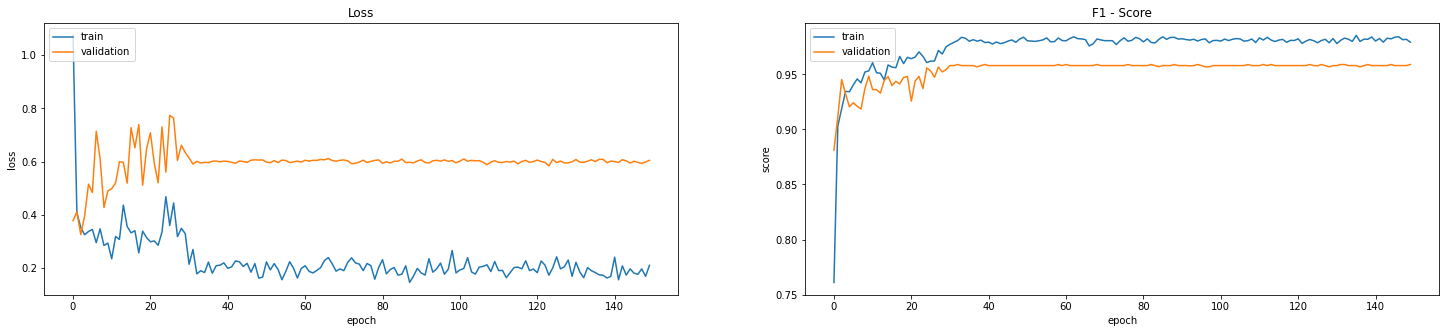

------------------------------ Second training ------------------------------


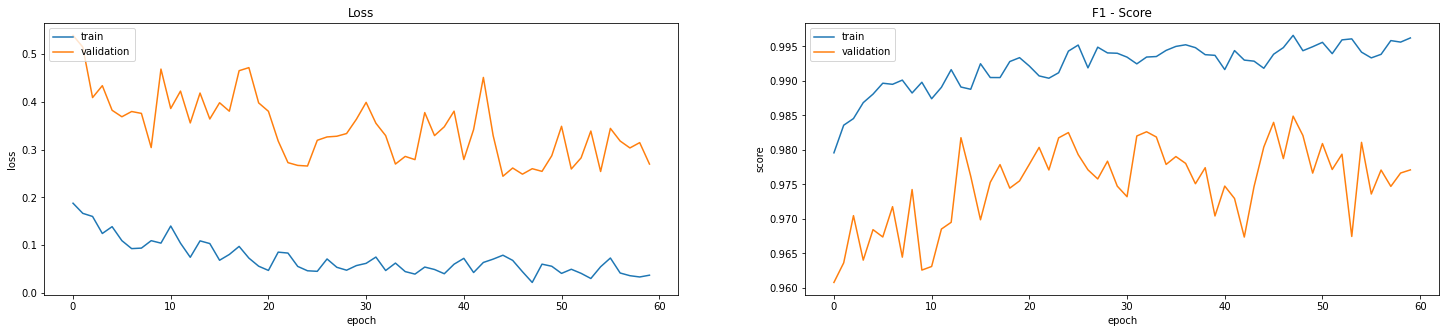

In [27]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################

plot_history(freeze_hist, name = "First training")
plot_history(hist, name = "Second training")

Une fois notre modèle entrainé, les poids du meilleur réseau ont été sauvegardés dans un fichier model_no_aug_best.h5.  

Nous rechargeons le modèle afin de l'évaluer sur notre jeu de test.   

In [22]:
model = keras.models.load_model('model_no_aug_best.h5')

In [23]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################
report = report_evaluation(model, test)

------------------------------ Evaluation Report ------------------------------ 

Test Size : Found 1500 validated image filenames.

Report : 

F1_score macro: 0.957842103068172
Accuracy:  0.964

                     precision    recall  f1-score   support

          airplane       1.00      0.82      0.90        11
  arrow_directions       0.94      0.98      0.96        59
              ball       0.94      1.00      0.97        29
            biking       1.00      1.00      1.00        15
              bird       0.89      0.91      0.90        34
             blade       0.78      1.00      0.88        14
              boat       0.95      0.93      0.94        43
             books       1.00      0.90      0.95        31
          building       1.00      0.94      0.97        47
        bunny_ears       0.96      0.92      0.94        24
      cartwheeling       1.00      0.94      0.97        16
             clock       0.97      1.00      0.98        63
             cloud    

## Annexe :  Fonctions utiles

In [25]:
def plot_history(hist, name = "Training"):
    print("-"*30, name, "-"*30)
    plt.figure(figsize=(25,5))
    
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","validation"], loc="upper left")
    
    plt.subplot(1,2,2)
    plt.plot(hist.history["f1_score"])
    plt.plot(hist.history["val_f1_score"])
    plt.title("F1 - Score")
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.legend(["train","validation"], loc="upper left")
    
    plt.show()

In [26]:
def report_evaluation(model, test_df, image_size=120, batch_size=32, verbose = 1):
    
    if verbose > 0:
        print("-"*30,"Evaluation Report","-"*30,"\n")
    datagen_test = ImageDataGenerator()
    
    if verbose > 0:
        print("Test Size :", end=' ')
    test_generator = datagen_test.flow_from_dataframe(dataframe=test_df, 
        x_col="name",
        shuffle=False,
        target_size=(image_size,image_size), 
        batch_size=batch_size,
        class_mode=None,
        rescale=1.0/255,
        seed=2020 )
    
    if verbose > 0:
        print("\nReport : \n")
    probabilities = model.predict(test_generator)
    y_pred = np.argmax(probabilities,1)
    y_test = np.array(test_df["label"])
    
    score_f1 = f1_score(y_test, y_pred, average="macro")
    score_acc = accuracy_score(y_test, y_pred)
    
    if verbose > 0:
        print("F1_score macro:", score_f1)
        print("Accuracy: ", score_acc)
        test_df["label_name"] = pd.Categorical(test_df["label_name"])
        class_indices = test_df["label_name"].cat.categories.tolist()
    
        print("\n",classification_report(y_test, y_pred, target_names=class_indices))
    
    return score_f1, score_acc, y_pred, y_test, np.max(probabilities,1)